In [4]:
%matplotlib inline
import sys
import os
sys.path.append("..")
# 自分のぱｓ
os.chdir("/Users/kokinakamura/git/HAI/main_server/hai")

import pymongo
from PIL import Image
from matplotlib import pylab as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as animation
import numpy as np
from bson.objectid import ObjectId
from sklearn.decomposition import PCA

from _app import app
from database import mongo

In [5]:
# pull images from DB
ims = mongo.images.find({'encryption': False,
                         'user_name': 'koki', 'utc_time': {"$gt": "2017/08/22 14:51:30"}}, 
                        sort=[("_id", pymongo.ASCENDING)])

In [30]:
# PCAと可視化

In [3]:
# 画像をカテゴリ分け
# featureとinfoのlistを作成
count = {'state_relaxed': 0, 'state_reading': 0, 'state_sleeping': 0}
count_valid = {'state_relaxed': 0, 'state_reading': 0, 'state_sleeping': 0}

state_relaxed = 0
state_reading = 0
state_sleeping = 0

info = []
features = []

ims = mongo.images.find({'encryption': False, 'user_name': 'koki', 'utc_time': {"$gt": "2017/08/22 14:51:30"}}, sort=[("_id", pymongo.ASCENDING)])

for im in ims:
    h = mongo.hue.find_one({'utc_time': {"$lt": im['utc_time']}}, sort=[("_id", pymongo.DESCENDING)])
    p = mongo.pose.find_one({'filename': im['filename']})
    if h['state']['xy'] == [0.5017, 0.4152]:
        state = 'state_relaxed'
    elif h['state']['xy'] == [0.4448, 0.4066]:
        state = 'state_reading'
    elif h['state']['xy'] == [0.5608, 0.4042]:
        state = 'state_sleeping'
    else:
        print(h['_id'])
        continue
    
    count[state] += 1
    
    if (p is not None) and (len(p['keypoints']['people']) == 1):
        features.append( p['keypoints']['people'][0]['pose_keypoints'])
        info.append({'state': state, 'utc_time': im['utc_time'], 'filename': im['filename']})
        count_valid[state] += 1

In [4]:
# PCAで2次元に次元削減
X = np.array(features)
pca = PCA(n_components=2)
pca.fit(X)
X_2d = pca.fit_transform(X)

In [5]:
colors = {'state_relaxed': 'royalblue', 'state_reading': 'coral', 'state_sleeping': 'seagreen'}

In [3]:
%matplotlib nbagg

num = len(X_2d)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

def set_axL(i):
    if i != 0:
        axL.scatter(X_2d[i-1][0], X_2d[i-1][1], color=colors[info[i-1]['state']])
    axL.scatter(X_2d[i][0], X_2d[i][1], color='r')
    axL.set_title('plot')
    axL.set_xlim(-1000, 1000)
    axL.set_ylim(-600, 1000)
    axL.grid(True)

def set_axR(i):
    im_path = app.config['RAW_IMG_DIR'] + info[i]['filename']
    img = Image.open(im_path, 'r')
    img_arr = np.array(img)
    axR.imshow(img_arr)
    axR.text(0.05, 1.05, str(i) ,horizontalalignment='left',verticalalignment='bottom', transform=axR.transAxes)
    axR.text(0.05, 1.0, info[i]['utc_time'] ,horizontalalignment='left',verticalalignment='bottom', transform=axR.transAxes)
    axR.set_title('pic')
    axR.grid(False)

set_axL(0)
set_axR(0)

def update_plot(i):
#     axL.clear()
    axR.clear()
    
    set_axL(i)
    set_axR(i)
    
    return axL, axR

ani = animation.FuncAnimation(fig, update_plot, frames=range(num), interval=500)
# ani.save('result.mp4', writer="ffmpeg")
fig.show()

ImportError: No module named 'matplotlib'

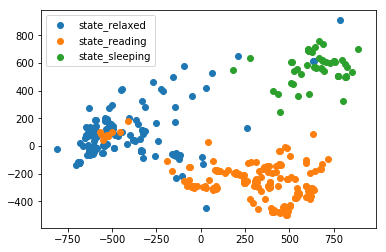

In [17]:
%matplotlib inline
for l in ['state_relaxed', 'state_reading', 'state_sleeping']:
    indices = [i['state'] == l  for i in info]
    points = X_2d[indices]
    plt.scatter(points[:, 0], points[:, 1], label=l)
    
plt.legend()
plt.show()

In [28]:
# 画像描画

In [8]:
ims = mongo.images.find({'encryption': False,
                         'user_name': 'koki', 'utc_time': {"$gt": "2017/08/22 14:51:30"}}, 
                        sort=[("_id", pymongo.ASCENDING)])

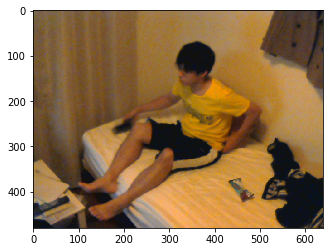

In [9]:
im = ims.next()
h = mongo.hue.find_one({'utc_time': {"$lt": im['utc_time']}}, sort=[("_id", pymongo.DESCENDING)])
p = mongo.pose.find_one({'filename': im['filename']})
im_path = app.config['RAW_IMG_DIR'] + im['filename']
img = np.array( Image.open(im_path, 'r') )
plt.imshow(img)

In [31]:
# svm

In [32]:
# svm用
svm_features = []
svm_y = []

ims = mongo.images.find({'encryption': False, 'user_name': 'koki', 'utc_time': {"$gt": "2017/08/22 14:51:30"}}, sort=[("_id", pymongo.ASCENDING)])

for im in ims:
    h = mongo.hue.find_one({'utc_time': {"$lt": im['utc_time']}}, sort=[("_id", pymongo.DESCENDING)])
    p = mongo.pose.find_one({'filename': im['filename']})
    if (p is not None) and (len(p['keypoints']['people']) == 1):
        if h['state']['xy'] == [0.5017, 0.4152]:
            svm_y.append(0)
        elif h['state']['xy'] == [0.4448, 0.4066]:
            svm_y.append(1)
        elif h['state']['xy'] == [0.5608, 0.4042]:
            svm_y.append(2)
        else:
            print(h['_id'])
            continue
        svm_features.append( p['keypoints']['people'][0]['pose_keypoints'])

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(svm_features, svm_y, train_size=0.8, random_state=1)

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [35]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
clf.predict(X_train)

array([0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 1,
       1, 1, 1, 1, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 2, 1, 2, 0, 1, 1, 0, 0, 1,
       1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0,
       1, 0, 2, 0, 1, 0, 1, 2, 1, 0, 0, 0, 2, 1, 2, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 2, 0, 2, 0, 1, 0, 1, 2, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       2, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 1, 2,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0,
       0, 2,

In [46]:
np.asarray(y_train)

array([0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 1,
       1, 1, 1, 1, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 2, 1, 2, 0, 1, 1, 0, 0, 1,
       1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0,
       1, 0, 2, 0, 1, 0, 1, 2, 1, 0, 0, 0, 2, 1, 2, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 2, 0, 2, 0, 1, 0, 1, 2, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       2, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 1, 2,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0,
       0, 2,

In [43]:
clf.predict(X_val)

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 2, 0, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 2, 0])

In [45]:
np.asarray(y_val)

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 2, 0, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 0,
       1, 2, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0])